In [1]:
import yaml
import pathlib
import pandas as pd
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn


import util

In [2]:
# Color style similar to ppt color scheme

plt.style.use('seaborn-colorblind')
# plt.rc('axes', prop_cycle=(plt.cycler('linestyle', ['-', '--', ':', '-.'])))

#Latex Default Font
plt.rc('font', family='serif') 
plt.rc('font', serif='Latin Modern Roman')
matplotlib.rcParams.update({'font.size': 16})

def make_hatches(ax, df):
    hatches = [h*len(df.index) for h in [['//'], ['--'], ['x'], ['\\'], ['||'], ['+'], ['o'], ['.']]]
    hatches = sum(hatches, [])

    if len(hatches) < len(ax.patches):
        print("Not enough hatches defined")
        
    for i,bar in enumerate(ax.patches):
        bar.set_hatch(hatches[i])
    ax.legend()

# Data Import and Cleaning

In [12]:
resBaseDir = pathlib.Path("results/latest")
thrResults = util.loadAllThroughput(resBaseDir / "throughputSuite")
sloResults = util.loadAllMlPerf(resBaseDir / "mlperfSuite", metric='completion_rate')
latResults = util.loadAllMlPerf(resBaseDir / "latDistribution", metric='p90')

thrResults

{'resnet50':          Actor        KaaS
 1   167.949836  142.412994
 2   167.890369  141.653048
 3   166.834229  140.584633
 4   167.779634  141.506064
 5     4.225877  140.794774
 6     2.716151  140.178871
 7     1.837293  140.584918
 8     1.721354  140.460991
 9     1.426165  140.746079
 10    1.250927  138.709481
 11    1.563266  140.398750
 12    1.442282  139.194187
 13    1.316498  138.921414
 14    1.230162  139.065794
 15    1.151174  138.990676
 16    1.083129  138.020498,
 'bert':         Actor       KaaS
 1   41.296571  41.658510
 2   42.105135  41.444021
 3   31.641339  41.130285
 4   42.033834  40.583645
 5    1.503967  40.489198
 6    0.975237  39.692855
 7    0.436330  39.572026
 8    0.349971  39.588785
 9    0.426402  39.561526
 10   0.379446  38.639820
 11   0.328569  26.495095
 12   0.318356  21.171284
 13   0.297567  16.887071
 14   0.280347  14.607447
 15   0.251693  13.480224
 16   0.235305  12.437228,
 'jacobi':         Actor       KaaS
 1   66.911350  45.05692

# Latency Distribution

In [4]:
def plotLatencies(lats, title="", log=True):
    cleanDfs = []
    for name, df in lats.items():
        cleanDfs.append(df.rename({'Actor': name + " Actor", 'KaaS': name + " KaaS"}, axis=1))
    pltDf = pd.concat(cleanDfs, axis=1).fillna(0) / 1000
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,4))
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,3), logy=log)
#     plot = pltDf.plot(kind='line', linewidth=2, logy=log)
    plot = seaborn.lineplot(data=pltDf, linewidth=3)

    plot.set_ylabel("90th Percentile Latency (s)")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, pltDf)
    
    plot.legend(bbox_to_anchor=(1,1))
    return plot

def plotNormalized(lats, log=False):
    plotDf = pd.DataFrame({workloadName: df.Actor / df.KaaS for workloadName, df in lats.items()})
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,4))
#     plot = plotDf.plot(kind='bar', width=0.7, figsize=(10,3), logy=log)
    plot = plotDf.plot(kind='line', linewidth=2, logy=log)
    plot.set_ylabel("90th Percentile Latency\n(ms)")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, plotDf)
    

    
# plotNormalized(latResults, log=False)

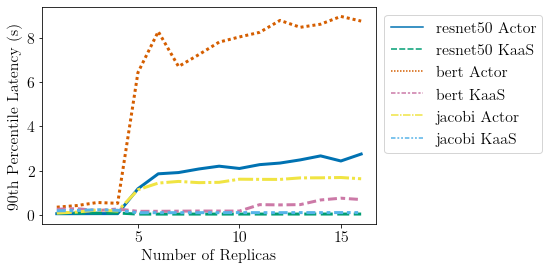

In [5]:
plot = plotLatencies(latResults)
# plot = plotLatencies({k: v for k, v in latResults.items() if k in ['resnet50', 'jacobi']}, log=True)
plot.figure.savefig("figs/latDistResults.png", dpi=300, bbox_inches='tight')

# CDFs

In [6]:
linestyles = [':', '--', '-.', (0, (3, 1, 1, 1, 1, 1)), '-']

def plotCDFs(names, arrs, title=''):
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(arrs, bins='auto', label=names, cumulative=True, density=True,
                               histtype='step', linewidth=2, linestyle='-')

    # Get rid of the zero value at the end (causes a vertical line)
    for idx, patch in enumerate(patches):
        patch[0].set_linestyle(linestyles[idx])
        patch[0].set_xy(patch[0].get_xy()[:-1])

    ax.set_xlabel("Latency (ms)")
    ax.legend(loc='lower right') 
    ax.set_title(title)
    

def loadCDFExps(configs):
    results = {}
    for model, mode, nReplica, independent in configs:
        expName = f"{model}_{mode}_{nReplica}"
        if independent:
            dirs = util.getRunDirs(resBaseDir / 'latIndependent', expNames=[expName])
        else:
            dirs = util.getRunDirs(resBaseDir / 'latDistribution', expNames=[expName])
            
        res, _ = util.loadOneMlPerf(dirs[expName])
        
        if mode == 'tvm':
            name = f"{model} Actor ({round(res['submission_rate'], 1)} qps)"
        else:
            name = f"{model} KaaS ({round(res['submission_rate'], 1)} qps)"
        
        results[name] = res['latencies']
        
    return results

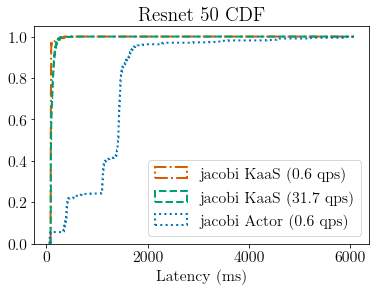

In [7]:
configs = [
    ('jacobi', 'tvm', 16, False),
    ('jacobi', 'kaas', 16, True),
    ('jacobi', 'kaas', 16, False)
]

cdfData = loadCDFExps(configs)
plotCDFs(cdfData.keys(), cdfData.values(), title="Resnet 50 CDF")
# plotCDFsSB(cdfData.keys(), cdfData.values(), title="Resnet 50 CDF")

# Online Experiment

In [8]:
def plotOnline(lats, title=""):
    cleanDfs = []
    for name, df in lats.items():
        cleanDfs.append(df.rename({'Actor': name + "(Actor)", 'KaaS': name + "(KaaS)"}, axis=1))
    pltDf = pd.concat(cleanDfs, axis=1).fillna(0)
    plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,3))
    #plot = pltDf.plot(kind='line', linewidth=2)
    plot.set_ylabel("Aggregate QPS")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, pltDf)
    
    plot.legend(bbox_to_anchor=(1,1))
    return plot

In [9]:
# plot = plotOnline(sloResults)
# plot.figure.savefig("figs/onlineResults.png", dpi=300, bbox_inches='tight')

# Throughput Experiments

In [10]:
def plotThroughput(dfs, title=""):
    cleanDfs = []
    for name, wlDf in dfs.items():
        cleanDfs.append(wlDf.rename({"KaaS": f"{name} KaaS", "Actor": f"{name} Actor"}, axis=1))
    pltDf = pd.concat(cleanDfs)
    plot = seaborn.lineplot(data=pltDf, linewidth=3)
    plot.set_ylabel("Aggregate QPS")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    plot.legend(bbox_to_anchor=(1,1))
    return plot

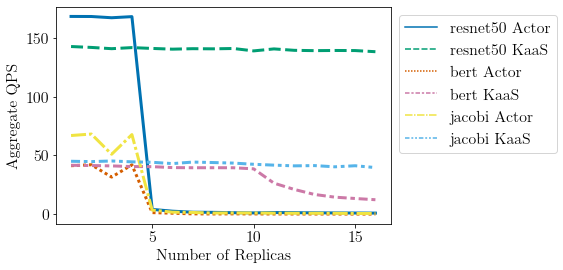

In [11]:
plot = plotThroughput(thrResults)
# plot = plotThroughput({ k: v for k, v in thrResults.items() if k in ['bert', 'jacobi']})
# plot = plotThroughput({ k: v for k, v in thrResults.items() if k in ['resnet50']})
plot.figure.savefig("figs/offlineResults.png", dpi=300, bbox_inches='tight')
# resnetPlt = plotThroughput(resnetDf)
# bertPlt = plotThroughput(bertDf)

# resnetPlt.figure.savefig("resnetOffline.png", dpi=300, bbox_inches='tight')
# bertPlt.figure.savefig("bertOffline.png", dpi=300, bbox_inches='tight')